# Notebook 01: Data Quality Control & Dataset Splitting

## Overview
This notebook prepares your audio dataset for machine learning by performing comprehensive quality control and creating stratified train/validation/test splits.

## Workflow
1. **Environment Verification** — Check Python dependencies and versions
2. **Data Discovery** — Scan `Segmented/` directory for audio files
3. **Manifest Consolidation** — Build master manifest from individual CSV files
4. **Data Validation** — Verify alignment between manifest and actual files
5. **Controlled Splitting** — Create leakage-safe, stratified splits with configurable parameters
6. **Export** — Save `train.csv`, `val.csv`, `test.csv` to `Manifests/`
---

In [1]:
# --- 0) Imports & Environment Check ---
import os, sys, glob
from pathlib import Path
import pandas as pd
import numpy as np
import soundfile as sf

from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

# Display environment info as table
env_info = pd.DataFrame({
    'Package': ['Python', 'pandas', 'numpy', 'soundfile', 'sklearn'],
    'Version': [
        sys.version.split()[0],
        pd.__version__,
        np.__version__,
        sf.__version__,
        __import__('sklearn').__version__
    ]
})
print("Environment Information:")
display(env_info)

Environment Information:


,Package,Version
0,Python,3.10.19
1,pandas,2.3.3
2,numpy,2.2.5
3,soundfile,0.13.1
4,sklearn,1.7.2


In [2]:
# --- 1) Project Paths ---
base_dir = Path("..").resolve()
segmented_dir = base_dir / "Segmented"
manifests_dir = base_dir / "Manifests"

# Display paths as table
path_info = pd.DataFrame({
    'Directory': ['Project Root', 'Segmented Data', 'Manifests'],
    'Path': [str(base_dir), str(segmented_dir), str(manifests_dir)],
    'Exists': [base_dir.exists(), segmented_dir.exists(), manifests_dir.exists()]
})
print("Project Directory Structure:")
display(path_info)

Project Directory Structure:


,Directory,Path,Exists
0,Project Root,/Users/dghifari/02-University/SEM-2-2025/elec5...,True
1,Segmented Data,/Users/dghifari/02-University/SEM-2-2025/elec5...,True
2,Manifests,/Users/dghifari/02-University/SEM-2-2025/elec5...,True


## 2) Scan segmented data — counts & quick QC

In [3]:
# Recursively find audio files under Segmented/
audio_exts = {'.wav', '.flac', '.mp3', '.m4a'}
seg_files = [p for p in segmented_dir.rglob("*") if p.suffix.lower() in audio_exts]

print(f"Found {len(seg_files)} segmented audio files\n")

# Infer family/instrument from directory layout Segmented/<family>/<instrument>/<file>.wav
def infer_family_instrument(path: Path):
    parts = path.relative_to(segmented_dir).parts
    fam = parts[0] if len(parts) >= 1 else None
    instr = parts[1] if len(parts) >= 2 else None
    return (fam, instr)

# Build a small dataframe for summary
seg_df = pd.DataFrame({
    "filepath": [str(p) for p in seg_files],
    "family_guess": [infer_family_instrument(p)[0] for p in seg_files],
    "instrument_guess": [infer_family_instrument(p)[1] for p in seg_files],
})

print("Family Distribution (inferred from folder structure):")
family_counts = seg_df['family_guess'].value_counts().sort_index()
display(family_counts.to_frame('count'))

print("\nInstrument Distribution (Top 10):")
instrument_counts = seg_df['instrument_guess'].value_counts().sort_index().head(10)
display(instrument_counts.to_frame('count'))

# Light accessibility check: try opening a few files
sample_paths = seg_files[:10]
ok, bad = 0, 0
for p in sample_paths:
    try:
        info = sf.info(str(p))
        ok += 1
    except Exception as e:
        bad += 1

print(f"\nFile Accessibility Check: Sampled {len(sample_paths)} files -> {ok} readable, {bad} errors")

Found 874 segmented audio files

Family Distribution (inferred from folder structure):


,count
family_guess,
keyboards,214
percussion,143
strings,142
voice,170
winds,205



Instrument Distribution (Top 10):


,count
instrument_guess,
bass,50
cello,22
clarinet,50
conga,9
cymbal,6
drum,110
flute,63
guitar,30
harpsichord,99



File Accessibility Check: Sampled 10 files -> 10 readable, 0 errors


## 3) Load or build a manifest

In [4]:
# === Consolidate all CSV manifests into Manifests/manifest_master.csv ===
from pathlib import Path
import pandas as pd, numpy as np

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".ogg", ".aiff", ".aif"}

def make_abs_path(rel: str) -> str:
    """Build an absolute path from a manifest's relative path."""
    p = Path(rel)
    if len(p.parts) and p.parts[0].lower() == "segmented":
        return str((segmented_dir.parent / p).resolve())
    return str((segmented_dir / p).resolve())

csv_paths = sorted(manifests_dir.glob("*.csv"))
csv_paths = [p for p in csv_paths if p.name not in ['train.csv', 'val.csv', 'test.csv', 'manifest_master.csv']]
assert csv_paths, f"No source CSVs found in {manifests_dir}"

rows = []
for p in csv_paths:
    try:
        df_i = pd.read_csv(p)
        df_i["_source_csv"]   = p.name
        df_i["_source_mtime"] = p.stat().st_mtime
        rows.append(df_i)
    except Exception as e:
        print(f"WARNING: Skipping {p.name}: {e}")

assert rows, "Could not read any of the CSV manifests."
full = pd.concat(rows, ignore_index=True)

# --- Normalize/rename columns to a common schema ---
if "filepath" not in full.columns:
    if "filepath_rel" in full.columns:
        full["filepath"] = full["filepath_rel"].astype(str).map(make_abs_path)
    elif "path" in full.columns:
        full["filepath"] = full["path"].astype(str).map(make_abs_path)
    else:
        raise AssertionError("No filepath or filepath_rel column found; cannot consolidate.")

if "family_label" not in full.columns:
    if "family" in full.columns:
        full["family_label"] = full["family"].astype(str)
    elif "label" in full.columns:
        full["family_label"] = full["label"].astype(str)
    else:
        full["family_label"] = np.nan

if "instrument_label" not in full.columns:
    if "Instrument" in full.columns:
        full["instrument_label"] = full["Instrument"].astype(str)
    elif "instrument" in full.columns:
        full["instrument_label"] = full["instrument"].astype(str)
    else:
        full["instrument_label"] = np.nan

full["family_label"]     = full["family_label"].astype(str).str.strip().str.lower().replace({"nan": np.nan})
full["instrument_label"] = full["instrument_label"].astype(str).str.strip().str.lower().replace({"nan": np.nan})

if "source_file" not in full.columns or full["source_file"].isna().all():
    from pathlib import Path as P
    full["source_file"] = full["filepath"].astype(str).apply(
        lambda x: P(x).parent.name if len(P(x).parts) > 1 else P(x).name
    )

# --- Deduplicate ---
full["_has_family"]     = full["family_label"].notna().astype(int)
full["_has_instrument"] = full["instrument_label"].notna().astype(int)

before = len(full)
full = full.sort_values(
    by=["_has_family", "_has_instrument", "_source_mtime"],
    ascending=[True, True, True]
).drop_duplicates(subset=["filepath"], keep="last")

# --- CRITICAL: Remove rows with invalid filepaths ---
# Filter out NaN or 'nan' string values in filepath
invalid_before = len(full)
full = full[full["filepath"].notna() & (full["filepath"] != 'nan')].copy()
invalid_removed = invalid_before - len(full)

after = len(full)

# --- Keep only essential columns for clean manifest ---
essential_cols = ["filepath", "family_label", "instrument_label", "source_file"]
optional_cols = ["duration_s", "rms_db", "fs", "clip_index"]
keep_cols = essential_cols + [c for c in optional_cols if c in full.columns]

# --- Finalize & save master ---
master_csv = manifests_dir / "manifest_master.csv"
full[keep_cols].to_csv(master_csv, index=False)

# --- Load master into df for downstream cells ---
df = pd.read_csv(master_csv)

# Quick health check: files exist?
missing = [p for p in df["filepath"].astype(str) if not Path(p).exists()]

# Create summary table
consolidation_summary = pd.DataFrame({
    'Metric': [
        'Source CSV Files',
        'Initial Rows',
        'After Deduplication',
        'Invalid Rows Removed',
        'Final Valid Rows',
        'Missing Files on Disk',
        'Labeled Families',
        'Unique Families'
    ],
    'Value': [
        len(csv_paths),
        before,
        invalid_before,
        invalid_removed,
        after,
        len(missing),
        f"{df['family_label'].notna().sum()}/{len(df)}",
        len(df['family_label'].dropna().unique())
    ]
})

print("Manifest Consolidation Summary:")
display(consolidation_summary)

print(f"\nAvailable Families: {sorted(df['family_label'].dropna().unique())}")
print(f"Saved to: {master_csv}")

print("\nSample Data Preview:")
display(df.head(5))

Manifest Consolidation Summary:


,Metric,Value
0,Source CSV Files,3
1,Initial Rows,2574
2,After Deduplication,874
3,Invalid Rows Removed,0
4,Final Valid Rows,874
5,Missing Files on Disk,0
6,Labeled Families,874/874
7,Unique Families,5



Available Families: ['keyboards', 'percussion', 'strings', 'voice', 'winds']
Saved to: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests/manifest_master.csv

Sample Data Preview:


,filepath,family_label,instrument_label,source_file,duration_s,rms_db,fs,clip_index
0,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum,percussion_drum_004,3,-37.536038,16000,28
1,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum,percussion_drum_004,3,-39.845277,16000,29
2,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum,percussion_drum_004,3,-36.102368,16000,30
3,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum,percussion_drum_004,3,-32.540497,16000,31
4,/Users/dghifari/02-University/SEM-2-2025/elec5...,percussion,drum,percussion_drum_004,3,-26.772069,16000,32


## 4) Manifest ↔ Files validation

In [5]:
# --- Validate master manifest vs Segmented/ contents ---

from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path("/Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154")
MANIFESTS = PROJECT_ROOT / "Manifests"
SEGMENTED = PROJECT_ROOT / "Segmented"
PREFER_MANIFEST_NAME = "manifest_master.csv"

PATH_COL_CANDIDATES = ["filepath", "filepath_rel", "path", "file_path", "fullpath", "full_path", "audio_path", "wav_path"]
AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".ogg", ".aiff", ".aif"}

# Pick the manifest CSV
if (MANIFESTS / PREFER_MANIFEST_NAME).exists():
    manifest_csv = MANIFESTS / PREFER_MANIFEST_NAME
else:
    csvs = sorted(MANIFESTS.glob("*.csv"))
    assert csvs, f"No CSVs found in {MANIFESTS}"
    manifest_csv = csvs[0]

# Load manifest and pick path column
df = pd.read_csv(manifest_csv)
path_col = next((c for c in PATH_COL_CANDIDATES if c in df.columns), None)
assert path_col is not None, f"None of {PATH_COL_CANDIDATES} found in {manifest_csv.name}"

# Normalize manifest paths to absolute
def to_abs(p: str) -> str:
    P = Path(str(p))
    if P.is_absolute():
        return str(P.resolve())
    if len(P.parts) and P.parts[0].lower() == "segmented":
        return str((PROJECT_ROOT / P).resolve())
    return str((SEGMENTED / P).resolve())

df["_abs_path"] = df[path_col].astype(str).map(to_abs)

# Collect all audio files actually on disk under Segmented/
disk_paths = {str(p.resolve()) for p in SEGMENTED.rglob("*") if p.suffix.lower() in AUDIO_EXTS}

# Compare
manifest_paths = set(df["_abs_path"].tolist())
missing_on_disk = sorted(p for p in manifest_paths if p not in disk_paths)
extra_on_disk   = sorted(p for p in disk_paths     if p not in manifest_paths)

# Create validation summary table
validation_summary = pd.DataFrame({
    'Category': ['Manifest Entries', 'Files on Disk', 'Missing Files', 'Extra Files'],
    'Count': [len(df), len(disk_paths), len(missing_on_disk), len(extra_on_disk)]
})

print("Manifest <-> Files Validation:")
display(validation_summary)

if len(missing_on_disk) == 0 and len(extra_on_disk) == 0:
    print("\nStatus: Perfect match")
else:
    print("\nStatus: Mismatch detected")

# Show examples if any issues
if missing_on_disk:
    print("\nMissing on Disk (in manifest but not found):")
    display(pd.DataFrame({"filepath": missing_on_disk}).head(5))
if extra_on_disk:
    print("\nExtra on Disk (found but not in manifest):")
    display(pd.DataFrame({"filepath": extra_on_disk}).head(5))

Manifest <-> Files Validation:


,Category,Count
0,Manifest Entries,874
1,Files on Disk,874
2,Missing Files,0
3,Extra Files,0



Status: Perfect match


## 5) Split controls (YOU decide)

In [6]:
# --- USER CONTROLS FOR SPLITTING ---
RANDOM_SEED = 42

# Fractions must sum to 1.0
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

# Column names
FAMILY_COLNAME = "family_label"
GROUP_KEY = "source_file"

# Splitting strategy
USE_GROUPING = True   # Prevents data leakage by keeping source files separate
USE_STRATIFY = True   # Maintains balanced class distribution

# Sanity check
assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6, "Splits must sum to 1.0"
labels = df[FAMILY_COLNAME].astype(str).values
groups = df[GROUP_KEY].astype(str).values
X = np.arange(len(df))

# Display configuration as table
config_table = pd.DataFrame({
    'Parameter': [
        'Random Seed',
        'Train Fraction',
        'Validation Fraction',
        'Test Fraction',
        'Family Column',
        'Grouping Key',
        'Use Grouping',
        'Use Stratification'
    ],
    'Value': [
        RANDOM_SEED,
        f'{TRAIN_FRAC:.0%}',
        f'{VAL_FRAC:.0%}',
        f'{TEST_FRAC:.0%}',
        FAMILY_COLNAME,
        GROUP_KEY,
        'Enabled' if USE_GROUPING else 'Disabled',
        'Enabled' if USE_STRATIFY else 'Disabled'
    ]
})

print("Split Configuration:")
display(config_table)

print("\nOverall Label Distribution:")
label_dist = df[FAMILY_COLNAME].value_counts().sort_index()
display(label_dist.to_frame('count'))

print(f"\nSplitting Strategy: {'GROUPED + STRATIFIED' if USE_GROUPING else 'STRATIFIED ONLY'}")
if USE_GROUPING:
    print("  - No data leakage: source files kept separate across splits")
    print("  - Balanced classes: stratification at group level")
else:
    print("  - WARNING: Potential data leakage if source files span multiple clips")

Split Configuration:


,Parameter,Value
0,Random Seed,42
1,Train Fraction,70%
2,Validation Fraction,15%
3,Test Fraction,15%
4,Family Column,family_label
5,Grouping Key,source_file
6,Use Grouping,Enabled
7,Use Stratification,Enabled



Overall Label Distribution:


,count
family_label,
keyboards,214
percussion,143
strings,142
voice,170
winds,205



Splitting Strategy: GROUPED + STRATIFIED
  - No data leakage: source files kept separate across splits
  - Balanced classes: stratification at group level


### 5A) Grouped split (leakage-safe, recommended)

In [7]:
# 5A) Grouped + Stratified split - PREVENTS DATA LEAKAGE + MAINTAINS BALANCE

if USE_GROUPING:
    from sklearn.model_selection import StratifiedShuffleSplit

    LABEL = FAMILY_COLNAME
    GROUP = GROUP_KEY
    assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-6

    print("Performing GROUPED + STRATIFIED split...")
    print("Ensures source files don't leak between splits while maintaining class balance\n")

    # Build group-level table
    grp = (df.groupby(GROUP)
             .agg(label_mode=(LABEL, lambda x: x.mode().iat[0] if len(x.mode()) else x.iloc[0]),
                  n_rows=(LABEL, "size"))
             .reset_index())

    print(f"Total unique source files: {len(grp)}")
    print(f"Source files per family:")
    display(grp['label_mode'].value_counts().sort_index().to_frame('count'))

    # Check if stratification is possible
    grp_counts = grp["label_mode"].value_counts()
    min_groups = grp_counts.min()
    print(f"\nSmallest family has {min_groups} source files")
    
    if min_groups < 3:
        print("WARNING: Some families have fewer than 3 source files!")
        print("Stratified splitting may fail.")
        display(grp_counts[grp_counts < 3].rename("num_source_files").to_frame())

    # Try multiple seeds to find valid split
    MAX_RETRIES = 500
    best = None
    best_balance_score = float('inf')
    all_fams = set(df[LABEL].dropna().unique())  # Only non-NaN families
    
    def has_all_fams(split_df): 
        return all_fams.issubset(set(split_df[LABEL].dropna().unique()))
    
    for k in range(MAX_RETRIES):
        seed = RANDOM_SEED + k
        try:
            # First split: train vs temp
            sss1 = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=seed)
            g_idx = np.arange(len(grp))
            y_g   = grp["label_mode"].values
            train_g_idx, temp_g_idx = next(sss1.split(g_idx, y_g))

            train_groups = set(grp.iloc[train_g_idx][GROUP])
            temp_grp     = grp.iloc[temp_g_idx].reset_index(drop=True)

            # Second split: val vs test
            sss2 = StratifiedShuffleSplit(
                n_splits=1,
                train_size=VAL_FRAC / (VAL_FRAC + TEST_FRAC),
                random_state=seed + 123
            )
            t_idx = np.arange(len(temp_grp))
            val_g_rel, test_g_rel = next(sss2.split(t_idx, temp_grp["label_mode"].values))
            val_groups  = set(temp_grp.iloc[val_g_rel][GROUP])
            test_groups = set(temp_grp.iloc[test_g_rel][GROUP])

            # Map back to rows
            train_df = df[df[GROUP].isin(train_groups)].copy()
            val_df   = df[df[GROUP].isin(val_groups)].copy()
            test_df  = df[df[GROUP].isin(test_groups)].copy()

            # Coverage check
            if has_all_fams(train_df) and has_all_fams(val_df) and has_all_fams(test_df):
                # Calculate balance score
                balance_score = 0
                for fam in all_fams:
                    overall_pct = (df[LABEL] == fam).sum() / len(df)
                    train_pct = (train_df[LABEL] == fam).sum() / len(train_df)
                    val_pct = (val_df[LABEL] == fam).sum() / len(val_df)
                    test_pct = (test_df[LABEL] == fam).sum() / len(test_df)
                    
                    balance_score += (train_pct - overall_pct)**2
                    balance_score += (val_pct - overall_pct)**2
                    balance_score += (test_pct - overall_pct)**2
                
                if balance_score < best_balance_score:
                    best = (train_df, val_df, test_df, seed, balance_score)
                    best_balance_score = balance_score
                    
                if balance_score < 0.001:
                    break
                    
        except ValueError:
            continue

    if best is None:
        print(f"\nWARNING: Couldn't find valid split after {MAX_RETRIES} attempts")
        print("Falling back to simple grouped split without perfect stratification")
        # Fallback to simpler splitting
        from sklearn.model_selection import GroupShuffleSplit
        gss1 = GroupShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=RANDOM_SEED)
        train_idx, temp_idx = next(gss1.split(X, labels, groups))
        
        temp_df = df.iloc[temp_idx]
        temp_groups = temp_df[GROUP].values
        temp_labels = temp_df[LABEL].values
        temp_X = np.arange(len(temp_df))
        
        gss2 = GroupShuffleSplit(n_splits=1, train_size=VAL_FRAC/(VAL_FRAC+TEST_FRAC), random_state=RANDOM_SEED+1)
        val_rel_idx, test_rel_idx = next(gss2.split(temp_X, temp_labels, temp_groups))
        
        train_df = df.iloc[train_idx].copy()
        val_df = temp_df.iloc[val_rel_idx].copy()
        test_df = temp_df.iloc[test_rel_idx].copy()
        
        print("Using fallback grouped split (may not be perfectly stratified)")
    else:
        train_df, val_df, test_df, used_seed, balance_score = best
        
        print(f"\nSplit Generation Results:")
        print(f"  Random seed used: {used_seed}")
        print(f"  Balance score: {balance_score:.6f} (lower is better)")
        print(f"  All {len(all_fams)} families present in all splits")
        
        # Verify no overlap
        train_groups_final = set(train_df[GROUP].unique())
        val_groups_final = set(val_df[GROUP].unique())
        test_groups_final = set(test_df[GROUP].unique())
        overlap = (train_groups_final & val_groups_final) | (train_groups_final & test_groups_final) | (val_groups_final & test_groups_final)
        assert len(overlap) == 0, f"CRITICAL: Group overlap detected! {overlap}"
        print(f"  Verified: No source file appears in multiple splits")
        
else:
    print("Grouped splitting disabled - skipping this cell")
    train_df = val_df = test_df = None

Performing GROUPED + STRATIFIED split...
Ensures source files don't leak between splits while maintaining class balance

Total unique source files: 67
Source files per family:


,count
label_mode,
keyboards,12
percussion,14
strings,11
voice,11
winds,19



Smallest family has 11 source files

Split Generation Results:
  Random seed used: 168
  Balance score: 0.019844 (lower is better)
  All 5 families present in all splits
  Verified: No source file appears in multiple splits


### 5B) Stratified split (only if you disable grouping)

In [8]:
# 5B) Stratified split (ONLY if grouping is disabled - NOT RECOMMENDED)

if not USE_GROUPING and USE_STRATIFY:
    from sklearn.model_selection import train_test_split
    
    print("WARNING: Performing stratified split WITHOUT grouping")
    print("This WILL cause DATA LEAKAGE - clips from same source in train+test!")
    print("Only use if you understand the implications.\n")
    
    print(f"Target splits: Train={TRAIN_FRAC:.0%}, Val={VAL_FRAC:.0%}, Test={TEST_FRAC:.0%}\n")
    
    # First split: train vs (val+test)
    train_df, temp_df = train_test_split(
        df,
        train_size=TRAIN_FRAC,
        random_state=RANDOM_SEED,
        stratify=df[FAMILY_COLNAME]
    )
    
    # Second split: val vs test
    val_size_relative = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_size_relative,
        random_state=RANDOM_SEED + 1,
        stratify=temp_df[FAMILY_COLNAME]
    )
    
    print("Stratified split completed (WITH DATA LEAKAGE)")
    print(f"  Train: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
    print(f"  Val:   {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
    print(f"  Test:  {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
    
elif USE_GROUPING:
    print("Grouping is enabled - using leakage-safe split from previous cell")
else:
    print("WARNING: No splitting method selected!")

Grouping is enabled - using leakage-safe split from previous cell


## 6) Split summaries & save to Manifests/

In [9]:
# --- Split summaries, leakage check, and save ---

# Sanity check
assert train_df is not None and val_df is not None and test_df is not None, \
    "Splitting did not run — check controls or missing variables."
assert len(train_df) + len(val_df) + len(test_df) == len(df), \
    "Row count mismatch — check that all data was assigned to a split!"

print("\nSplit Distribution Summary")
print("-" * 50)

# Create split size summary table
split_sizes = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(train_df), len(val_df), len(test_df), len(df)],
    'Percentage': [
        f"{len(train_df)/len(df)*100:.1f}%",
        f"{len(val_df)/len(df)*100:.1f}%",
        f"{len(test_df)/len(df)*100:.1f}%",
        "100.0%"
    ]
})
print("\nSplit Sizes:")
display(split_sizes)

# Family distribution per split
print("\nFamily Distribution per Split:")
valid_families = sorted([f for f in df[FAMILY_COLNAME].unique() if pd.notna(f)])
family_dist = pd.DataFrame({
    'Family': valid_families,
    'Train': [train_df[train_df[FAMILY_COLNAME] == f].shape[0] for f in valid_families],
    'Val': [val_df[val_df[FAMILY_COLNAME] == f].shape[0] for f in valid_families],
    'Test': [test_df[test_df[FAMILY_COLNAME] == f].shape[0] for f in valid_families]
})
display(family_dist)

# Balance quality check
print("\nClass Balance Quality:")
balance_data = []
for family in valid_families:
    overall_pct = (df[FAMILY_COLNAME] == family).sum() / len(df) * 100
    train_pct = (train_df[FAMILY_COLNAME] == family).sum() / len(train_df) * 100
    val_pct = (val_df[FAMILY_COLNAME] == family).sum() / len(val_df) * 100
    test_pct = (test_df[FAMILY_COLNAME] == family).sum() / len(test_df) * 100
    
    balance_data.append({
        'Family': family,
        'Overall': f'{overall_pct:.1f}%',
        'Train': f'{train_pct:.1f}%',
        'Val': f'{val_pct:.1f}%',
        'Test': f'{test_pct:.1f}%'
    })

balance_table = pd.DataFrame(balance_data)
display(balance_table)

# Data leakage verification
print("\nData Leakage Verification")
print("-" * 50)

if GROUP_KEY in train_df.columns:
    train_sources = set(train_df[GROUP_KEY].unique())
    val_sources = set(val_df[GROUP_KEY].unique())
    test_sources = set(test_df[GROUP_KEY].unique())
    
    train_val_overlap = train_sources & val_sources
    train_test_overlap = train_sources & test_sources
    val_test_overlap = val_sources & test_sources
    total_overlap = len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap)
    
    print(f"\nUnique source files:")
    print(f"  Train: {len(train_sources)}")
    print(f"  Val:   {len(val_sources)}")
    print(f"  Test:  {len(test_sources)}")
    print(f"\nOverlap check:")
    print(f"  Train ∩ Val:  {len(train_val_overlap)} source files")
    print(f"  Train ∩ Test: {len(train_test_overlap)} source files")
    print(f"  Val ∩ Test:   {len(val_test_overlap)} source files")
    
    if total_overlap == 0:
        print("\nStatus: NO DATA LEAKAGE DETECTED")
        print("Source files are completely separate across splits.")
    else:
        print(f"\nStatus: DATA LEAKAGE DETECTED ({total_overlap} overlapping source files)")
        print("Re-run with USE_GROUPING=True to fix this.")
        if len(train_test_overlap) > 0:
            print(f"\nExamples of leaked sources (train+test):")
            for src in sorted(train_test_overlap)[:5]:
                print(f"  - {src}")
else:
    print("WARNING: GROUP_KEY column not found - cannot verify leakage")

# Save split files
print("\nSaving Split Files")
print("-" * 50)

out_train = manifests_dir / "train.csv"
out_val   = manifests_dir / "val.csv"
out_test  = manifests_dir / "test.csv"

# Add split indicator
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Save individual splits
train_df.to_csv(out_train, index=False)
val_df.to_csv(out_val, index=False)
test_df.to_csv(out_test, index=False)

# Update master manifest
df_with_splits = pd.concat([train_df, val_df, test_df], ignore_index=True)
df_with_splits.to_csv(manifests_dir / "manifest_master.csv", index=False)

print(f"\nSaved files:")
print(f"  - {out_train.name} ({len(train_df)} rows)")
print(f"  - {out_val.name} ({len(val_df)} rows)")
print(f"  - {out_test.name} ({len(test_df)} rows)")
print(f"  - manifest_master.csv (updated with split indicators)")

print(f"\nLocation: {manifests_dir}")


Split Distribution Summary
--------------------------------------------------

Split Sizes:


,Split,Samples,Percentage
0,Train,685,78.4%
1,Validation,79,9.0%
2,Test,110,12.6%
3,Total,874,100.0%



Family Distribution per Split:


,Family,Train,Val,Test
0,keyboards,173,20,21
1,percussion,111,15,17
2,strings,116,5,21
3,voice,126,17,27
4,winds,159,22,24



Class Balance Quality:


,Family,Overall,Train,Val,Test
0,keyboards,24.5%,25.3%,25.3%,19.1%
1,percussion,16.4%,16.2%,19.0%,15.5%
2,strings,16.2%,16.9%,6.3%,19.1%
3,voice,19.5%,18.4%,21.5%,24.5%
4,winds,23.5%,23.2%,27.8%,21.8%



Data Leakage Verification
--------------------------------------------------

Unique source files:
  Train: 46
  Val:   10
  Test:  11

Overlap check:
  Train ∩ Val:  0 source files
  Train ∩ Test: 0 source files
  Val ∩ Test:   0 source files

Status: NO DATA LEAKAGE DETECTED
Source files are completely separate across splits.

Saving Split Files
--------------------------------------------------

Saved files:
  - train.csv (685 rows)
  - val.csv (79 rows)
  - test.csv (110 rows)
  - manifest_master.csv (updated with split indicators)

Location: /Users/dghifari/02-University/SEM-2-2025/elec5305-project-520140154/Manifests



Dataset Overview
--------------------------------------------------

Family Distribution:


,count
family_label,
keyboards,214
percussion,143
strings,142
voice,170
winds,205



Subfamily (Family + Instrument) Distribution:


,family_label,instrument_label,count
6,percussion,drum,110
0,keyboards,harpsichord,99
15,voice,sing,78
18,winds,flute,63
2,keyboards,piano,61
14,voice,hum,52
9,strings,bass,50
17,winds,clarinet,50
21,winds,trumpet,44
16,voice,spoken,40


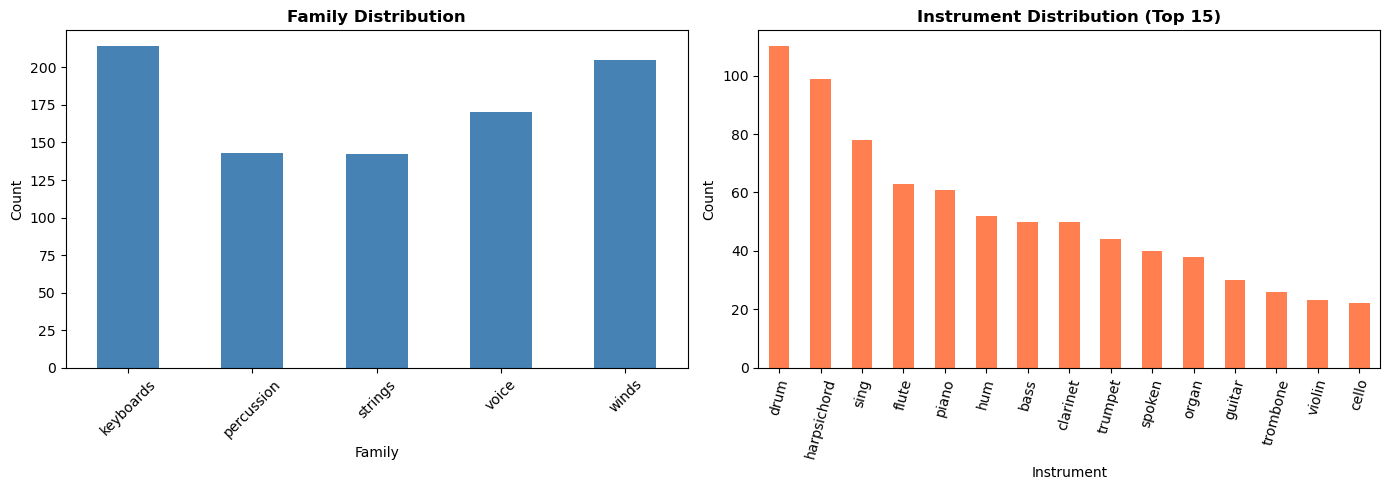


Data Preparation Complete
--------------------------------------------------

Final Dataset Statistics:


,Metric,Value
0,Total Samples,874
1,Unique Source Files,67
2,Families,5
3,Instruments,22
4,Train Samples,685
5,Val Samples,79
6,Test Samples,110



Ready for model training with leakage-safe splits.


In [10]:
# --- Dataset overview and completion summary ---

print("\nDataset Overview")
print("-" * 50)

# Family counts
print("\nFamily Distribution:")
family_summary = df[FAMILY_COLNAME].value_counts().sort_index()
display(family_summary.to_frame('count'))

# Subfamily (family + instrument) counts
if "instrument_label" in df.columns:
    print("\nSubfamily (Family + Instrument) Distribution:")
    subfamily_summary = (
        df.groupby([FAMILY_COLNAME, "instrument_label"])
          .size()
          .rename("count")
          .reset_index()
          .sort_values(["count"], ascending=False)
    )
    display(subfamily_summary.head(20))
else:
    print("\nInstrument labels not available")

# Visualizations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Family distribution
family_summary.plot(kind="bar", ax=axes[0], color='steelblue')
axes[0].set_title("Family Distribution", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Family")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Instrument distribution
if "instrument_label" in df.columns:
    instrument_counts = df.groupby("instrument_label").size().sort_values(ascending=False)
    instrument_counts.head(15).plot(kind="bar", ax=axes[1], color='coral')
    axes[1].set_title("Instrument Distribution (Top 15)", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Instrument")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

# Completion summary
print("\nData Preparation Complete")
print("-" * 50)

# Dataset statistics table
dataset_stats = pd.DataFrame({
    'Metric': [
        'Total Samples',
        'Unique Source Files',
        'Families',
        'Instruments',
        'Train Samples',
        'Val Samples',
        'Test Samples'
    ],
    'Value': [
        len(df),
        len(df[GROUP_KEY].unique()),
        len(df[FAMILY_COLNAME].dropna().unique()),
        len(df['instrument_label'].dropna().unique()) if 'instrument_label' in df.columns else 'N/A',
        len(train_df),
        len(val_df),
        len(test_df)
    ]
})

print("\nFinal Dataset Statistics:")
display(dataset_stats)

print("\nReady for model training with leakage-safe splits.")